In [1]:
# noise = generate_fractal_noise_2d(shape = (256,256), res = (2,2), octaves = 2, persistence = 0.5, lacunarity = 2, tileable = (False, False))

In [2]:
# fig, axis = plt.subplots(1, 1, figsize=(6,6), sharex = False, sharey = False, squeeze = False)
# # axis[0,0].imshow(noise)
# plotMesh(xx, yy, noise, axis[0,0], fig)

In [111]:

# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import time
import torch
from torch_geometric.loader import DataLoader
import argparse
import yaml
from torch_geometric.nn import radius
from torch.optim import Adam
import torch.autograd.profiler as profiler
from torch.profiler import profile, record_function, ProfilerActivity

# from rbfConv import RbfConv
# from dataset import compressedFluidDataset, prepareData

import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))
%matplotlib notebook
import copy

import time
import torch
from torch_geometric.loader import DataLoader
from tqdm.notebook import trange, tqdm
import argparse
import yaml
from torch_geometric.nn import radius
from torch.optim import Adam
import torch.autograd.profiler as profiler
from torch.profiler import profile, record_function, ProfilerActivity

# from rbfConv import RbfConv
# from dataset import compressedFluidDataset, prepareData

import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))


import tomli
from scipy.optimize import minimize
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt

import math
from scipy import interpolate

import numpy as np
# %matplotlib notebook
import matplotlib.pyplot as plt

import scipy.special

from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# import triangle as tr
from scipy.optimize import minimize

# np
from itertools import product

# seed = 0


# import random 
# import numpy as np
# random.seed(seed)
# torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
# np.random.seed(seed)
# # print(torch.cuda.device_count())
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# # print('running on: ', device)
# torch.set_num_threads(1)

# from joblib import Parallel, delayed

# # from cutlass import *
# # from rbfConv import *
# # from tqdm.notebook import tqdm

# # from datautils import *
# # # from sphUtils import *
# # from lossFunctions import *
# import math
# from scipy import interpolate

# import numpy as np
# %matplotlib notebook
# import matplotlib.pyplot as plt

# import scipy.special

# from numpy.random import MT19937
# from numpy.random import RandomState, SeedSequence

# import ipywidgets as widgets
# from ipywidgets import interact, interact_manual

# # import triangle as tr
# from scipy.optimize import minimize

# # np
# from itertools import product

import numpy as np


def interpolant(t):
    return t*t*t*(t*(t*6 - 15) + 10)


def generate_perlin_noise_2d(
        shape, res, tileable=(False, False), interpolant=interpolant, rng = np.random.default_rng(seed=42)
):
    """Generate a 2D numpy array of perlin noise.

    Args:
        shape: The shape of the generated array (tuple of two ints).
            This must be a multple of res.
        res: The number of periods of noise to generate along each
            axis (tuple of two ints). Note shape must be a multiple of
            res.
        tileable: If the noise should be tileable along each axis
            (tuple of two bools). Defaults to (False, False).
        interpolant: The interpolation function, defaults to
            t*t*t*(t*(t*6 - 15) + 10).

    Returns:
        A numpy array of shape shape with the generated noise.

    Raises:
        ValueError: If shape is not a multiple of res.
    """
    delta = (res[0] / shape[0], res[1] / shape[1])
    d = (shape[0] // res[0], shape[1] // res[1])
    grid = np.mgrid[0:res[0]:delta[0], 0:res[1]:delta[1]]\
             .transpose(1, 2, 0) % 1
    # Gradients
    angles = 2*np.pi*rng.random((res[0]+1, res[1]+1))
    gradients = np.dstack((np.cos(angles), np.sin(angles)))
    if tileable[0]:
        gradients[-1,:] = gradients[0,:]
    if tileable[1]:
        gradients[:,-1] = gradients[:,0]
    gradients = gradients.repeat(d[0], 0).repeat(d[1], 1)
    g00 = gradients[    :-d[0],    :-d[1]]
    g10 = gradients[d[0]:     ,    :-d[1]]
    g01 = gradients[    :-d[0],d[1]:     ]
    g11 = gradients[d[0]:     ,d[1]:     ]
    # Ramps
    n00 = np.sum(np.dstack((grid[:,:,0]  , grid[:,:,1]  )) * g00, 2)
    n10 = np.sum(np.dstack((grid[:,:,0]-1, grid[:,:,1]  )) * g10, 2)
    n01 = np.sum(np.dstack((grid[:,:,0]  , grid[:,:,1]-1)) * g01, 2)
    n11 = np.sum(np.dstack((grid[:,:,0]-1, grid[:,:,1]-1)) * g11, 2)
    # Interpolation
    t = interpolant(grid)
    n0 = n00*(1-t[:,:,0]) + t[:,:,0]*n10
    n1 = n01*(1-t[:,:,0]) + t[:,:,0]*n11
    return np.sqrt(2)*((1-t[:,:,1])*n0 + t[:,:,1]*n1)


def generate_fractal_noise_2d(
        shape, res, octaves=1, persistence=0.5,
        lacunarity=2, tileable=(False, False),
        interpolant=interpolant, seed = 1337
):
    """Generate a 2D numpy array of fractal noise.

    Args:
        shape: The shape of the generated array (tuple of two ints).
            This must be a multiple of lacunarity**(octaves-1)*res.
        res: The number of periods of noise to generate along each
            axis (tuple of two ints). Note shape must be a multiple of
            (lacunarity**(octaves-1)*res).
        octaves: The number of octaves in the noise. Defaults to 1.
        persistence: The scaling factor between two octaves.
        lacunarity: The frequency factor between two octaves.
        tileable: If the noise should be tileable along each axis
            (tuple of two bools). Defaults to (False, False).
        interpolant: The, interpolation function, defaults to
            t*t*t*(t*(t*6 - 15) + 10).

    Returns:
        A numpy array of fractal noise and of shape shape generated by
        combining several octaves of perlin noise.

    Raises:
        ValueError: If shape is not a multiple of
            (lacunarity**(octaves-1)*res).
    """
    rng = np.random.default_rng(seed=seed)
    
    noise = np.zeros(shape)
    frequency = 1
    amplitude = 1
    for _ in range(octaves):
        noise += amplitude * generate_perlin_noise_2d(
            shape, (frequency*res[0], frequency*res[1]), tileable, interpolant, rng
        )
        frequency *= lacunarity
        amplitude *= persistence
    return noise

@torch.jit.script
def sdPoly(poly, p):    
    with record_function("sdPoly"): 
        N = len(poly)

        i = torch.arange(N, device = p.device, dtype = torch.int64)
        i2 = (i + 1) % N
        e = poly[i2] - poly[i]
        v = p - poly[i][:,None]

        ve = torch.einsum('npd, nd -> np', v, e)
        ee = torch.einsum('nd, nd -> n', e, e)

        pq = v - e[:,None] * torch.clamp(ve / ee[:,None], min = 0, max = 1)[:,:,None]

        d = torch.einsum('npd, npd -> np', pq, pq)
        d = torch.min(d, dim = 0).values

        wn = torch.zeros((N, p.shape[0]), device = p.device, dtype = torch.int64)

        cond1 = 0 <= v[i,:,1]
        cond2 = 0 >  v[i2,:,1]
        val3 = e[i,0,None] * v[i,:,1] - e[i,1,None] * v[i,:,0]

        c1c2 = torch.logical_and(cond1, cond2)
        nc1nc2 = torch.logical_and(torch.logical_not(cond1), torch.logical_not(cond2))

        wn[torch.logical_and(c1c2, val3 > 0)] += 1
        wn[torch.logical_and(nc1nc2, val3 < 0)] -= 1

        wn = torch.sum(wn,dim=0)
        s = torch.ones(p.shape[0], device = p.device, dtype = p.dtype)
        s[wn != 0] = -1

        return s * torch.sqrt(d)
@torch.jit.script
def sdPolyDer(poly, p, dh :float = 1e-4, inverted :bool = False):
    with record_function("sdPolyDer"): 
#         dh = 1e-2
        dpx = torch.zeros_like(p)
        dnx = torch.zeros_like(p)
        dpy = torch.zeros_like(p)
        dny = torch.zeros_like(p)

        dpx[:,0] += dh
        dnx[:,0] -= dh
        dpy[:,1] += dh
        dny[:,1] -= dh

        c = sdPoly(poly, p)
        cpx = sdPoly(poly, p + dpx)
        cnx = sdPoly(poly, p + dnx)
        cpy = sdPoly(poly, p + dpy)
        cny = sdPoly(poly, p + dny)

        if inverted:
            c = -c
            cpx = -cpx
            cnx = -cnx
            cpy = -cpy
            cny = -cny

        grad = torch.zeros_like(p)
        grad[:,0] = (cpx - cnx) / (2 * dh)
        grad[:,1] = (cpy - cny) / (2 * dh)

        gradLen = torch.linalg.norm(grad, dim =1)
        grad[torch.abs(gradLen) > 1e-5] /= gradLen[torch.abs(gradLen)>1e-5,None]

        return c, grad, cpx, cnx, cpy, cny
    
def buildSDF(poly, minCoord = [-1,-1], maxCoord = [1,1], n = 256, dh = 1e-2):
    
    x = np.linspace(minCoord[0],maxCoord[0],n)
    y = np.linspace(minCoord[1],maxCoord[1],n)

    xx, yy = np.meshgrid(x,y)

    sdf, sdfGrad, _, _, _, _ = sdPolyDer(torch.tensor(poly[:-1,:]), torch.tensor(np.vstack((yy.flatten(),xx.flatten()))).mT, dh = dh)
    
    return xx, yy, sdf, sdfGrad
def plotMesh(xx,yy,z, axis, fig):
    im = axis.pcolormesh(xx,yy,z)
    axis.axis('equal')
    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("bottom", size="7%", pad="2%")
    cbar = fig.colorbar(im, cax=cax1,orientation='horizontal')
    cbar.ax.tick_params(labelsize=8)
    
    
def createNoiseFunction(n = 256, res = 2, octaves = 2, lacunarity = 2, persistance = 0.5, seed = 1336):
    noise = generate_fractal_noise_2d(shape = (n,n), res = (res,res), octaves = octaves, persistence = persistance, lacunarity = lacunarity, tileable = (False, False), seed = seed)
#     noise = Octave(n, octaves = octaves, lacunarity = lacunarity, persistance = persistance, seed = seed)

#     noise[:,0] = noise[:,1] - noise[:,2] + noise[:,1]
#     noise[0,:] = noise[1,:] - noise[2,:] + noise[1,:]

#     noise = noise[:n,:n] / 255
    x = np.linspace(-1,1,n)
    y = np.linspace(-1,1,n)
    xx, yy = np.meshgrid(x,y)

    f = interpolate.RegularGridInterpolator((x, y), noise, bounds_error = False, fill_value = None, method = 'linear')
    
    return f, noise

def createVelocityField(f, n = 256, dh = 1e-4):
    x = np.linspace(-1,1,n)
    y = np.linspace(-1,1,n)

    xx, yy = np.meshgrid(x,y)

    z = f((xx, yy))
    zxp = f((xx + dh, yy))
    zxn = f((xx -dh, yy))
    zyp = f((xx, yy + dh))
    zyn = f((xx, yy - dh))
    yv = (zxp - zxn) / (2 * dh)
    xv = -(zyp - zyn) / (2 * dh)
#     print(xv)
#     print(yv)
    
    return np.stack((xv, yv), axis = 2), xx, yy, z

def createPotentialField(n = 256, res = 4, octaves = 2, lacunarity = 2, persistance = 0.5, seed = 1336):
    f, noise = createNoiseFunction(n = n, res = res, octaves = octaves, lacunarity = lacunarity, persistance = persistance, seed = 1336)
#     noise = Octave(n, octaves = octaves, lacunarity = lacunarity, persistance = persistance, seed = seed)

#     noise[:,0] = noise[:,1] - noise[:,2] + noise[:,1]
#     noise[0,:] = noise[1,:] - noise[2,:] + noise[1,:]

#     noise = noise[:n,:n] / 255
    x = np.linspace(-1,1,n)
    y = np.linspace(-1,1,n)
    xx, yy = np.meshgrid(x,y)

#     f = interpolate.RegularGridInterpolator((x, y), noise, bounds_error = False, fill_value = None, method = 'linear')
    
    return xx,yy,noise

# def filterPotential(noise, sdf, d0 = 0.25):
#     r = sdf / d0
# #     ramped = r * r * (3 - 2 * r)
#     ramped = 15/8 * r - 10/8 * r**3 + 3/8 * r**5
# #     ramped = r
#     ramped[r >= 1] = 1
#     ramped[r <= 0] = 0
# #     ramped[r <= -1] = -1
    
#     return ramped * noise
#     # ramped = r
    
# def filterPotential(noise, sdf, d0 = 0.25):
#     r = sdf / d0 /2  + 0.5
# #     ramped = r * r * (3 - 2 * r)
#     ramped = 15/8 * r - 10/8 * r**3 + 3/8 * r**5
# #     ramped = r
#     ramped[r >= 1] = 1
#     ramped[r <= 0] = 0
# #     ramped[r <= -1] = -1
    
#     return ramped * noise
#     # ramped = r
    
def generateParticles(nd, nb, border = 3):
    if not isinstance(nd, np.ndarray):
        nd = np.array([nd,nd])
    if not isinstance(nb, np.ndarray):
        nb = np.array([nb,nb])
#     nd = 16
    nc = 2 * nd
#     nb = 32
    na = 2 * nb + nc
#     border = 3
    xi = np.arange(-border, na[0] + border, dtype = int) + border
    yi = np.arange(-border, na[1] + border, dtype = int) + border
    dx = 2 / (na[0] - 1) if na[0] > na[1] else 2 / (na[1] - 1)
    dy = dx
    px = xi * dx - 1 - border * dx
    
    
    py = yi * dy - 1 - border * dy
    # print(xi)
    # print(x)
    xx, yy = np.meshgrid(px,py)
    xxi, yyi = np.meshgrid(xi,yi)

    c = np.ones_like(xx)
#     print(xx.shape)

    c[xxi < border] = -1
    c[xxi >= na[0] + border] = -1
    c[yyi < border] = -1
    c[yyi >= na[1] + border] = -1
#     print(np.sum(c > 0) - 96**2)
    # print(96**2)

    maskA = xxi >= border + nb[0]
    maskB = yyi >= border + nb[1]
    maskAB = np.logical_and(maskA, maskB)

    maskC = xxi < border + nb[0] + nc[0]
    maskD = yyi < border + nb[1] + nc[1]
    maskCD = np.logical_and(maskC, maskD)

    mask = np.logical_and(maskAB, maskCD)
#     print(np.sum(mask))
    c[mask] = -1

    maskA = xxi >= 2 * border + nb[0]
    maskB = yyi >= 2 * border + nb[1]
    maskAB = np.logical_and(maskA, maskB)

    maskC = xxi < border + nb[0] + nc[0] - border
    maskD = yyi < border + nb[1] + nc[1] - border
    maskCD = np.logical_and(maskC, maskD)

    mask = np.logical_and(maskAB, maskCD)
#     print(np.sum(mask))
    c[mask] = 0.25
    # c[:,:] = -0.5


    minDomain = -1 - dx / 2
    minCenter = - nd * dx# - dx / 2
#     print(dx)
#     print(-nd * dx)
#     print(minCenter)


#     fig, axis = plt.subplots(1, 1, figsize=(6,6), sharex = False, sharey = False, squeeze = False)

    ptcls = np.vstack((xx[c > 0.5], yy[c>0.5])).transpose()
    bdyPtcls = np.vstack((xx[c < -0.5], yy[c <-0.5])).transpose()
    
    center = (np.max(bdyPtcls,axis=0) + np.min(bdyPtcls,axis=0))/2
#     print(center)
    ptcls = ptcls - center
    bdyPtcls = bdyPtcls - center
    minDomain = np.min(bdyPtcls,axis=0) + (border - .5) * dx
    
    return ptcls, bdyPtcls, minDomain, minCenter

def genParticles(nd = 8, nb = 16, border = 3, n = 256, res = 2, octaves = 4, lacunarity = 2, persistance = 0.25, seed = 1336, boundary = 0.25, dh = 1e-3):
    ptcls, bdyPtcls, minDomain, minCenter = generateParticles(nd, nb, border = border)

#     dh = 1e-3

#     boundary = 0.25

    c = -minCenter
    domainBoundary = np.array([[minDomain[0] + boundary,minDomain[1] + boundary],[-minDomain[0] - boundary,minDomain[1] + boundary], [-minDomain[0] - boundary,-minDomain[1] - boundary],[minDomain[0] + boundary,-minDomain[1] - boundary],[minDomain[0] + boundary,minDomain[1] + boundary]])
    centerBoundary = np.array([[-c[0],-c[1]],[c[0],-c[1]],[c[0],c[1]],[-c[0],c[1]],[-c[0],-c[1]]])

    _, _, polySDF, polySDFGrad = buildSDF(centerBoundary, n = n, dh = dh)
    _, _, domainSDF, domainSDFGrad = buildSDF(domainBoundary, n = n, dh = dh)
    # _, _, domainSDF, domainSDFGrad = buildSDF(np.array([[-1.0 ,-1 ],[1 ,-1 ],\
    #                                                     [1 ,1 ],[-1 ,1 ],[-1 ,-1 ]]), n = 256, dh = dh)

    # poly, shape = buildPolygon()
    # xx, yy, polySDF, polySDFGrad = buildSDF(poly, n = 256)
    s = (- domainSDF + boundary).numpy()
    s = s.reshape(polySDF.shape)
    # s = - domainSDF



    xx, yy, noise = createPotentialField(n = n, res = res, octaves = octaves, lacunarity = lacunarity, persistance = persistance, seed = seed)
    filtered = noise
    
    filtered = filterPotential(torch.tensor(filtered).flatten(), torch.tensor(s).flatten(), d0 = boundary ).numpy().reshape(noise.shape)
    if np.any(nd > 0):
        filtered = filterPotential(torch.tensor(filtered).flatten(), torch.tensor(polySDF).flatten(), d0 = boundary).numpy().reshape(noise.shape)
        filtered[polySDF.reshape(noise.shape) < 0] = 0

    x = np.linspace(-1,1,n)
    y = np.linspace(-1,1,n)
    f = interpolate.RegularGridInterpolator((x, y), filtered, bounds_error = False, fill_value = None, method = 'linear')

    velocityField, xx, yy, potential = createVelocityField(f, n = n, dh = 2 / (np.max(nd) + np.max(nb)) / 2)  
#     print(filtered)
    
    f = interpolate.RegularGridInterpolator((x, y), velocityField, bounds_error = False, fill_value = None, method = 'linear')
    vel = f((ptcls[:,0], ptcls[:,1]))
    
    
    domainBoundaryActual = np.array([[minDomain[0],minDomain[1]],[-minDomain[0],minDomain[1]], [-minDomain[0],-minDomain[1]],[minDomain[0],-minDomain[1]],[minDomain[0],minDomain[1]]])
    sdf, sdfDer, _, _, _, _ = sdPolyDer(torch.tensor(domainBoundaryActual[:-1]), torch.tensor(bdyPtcls), dh = 1e-2)
    domainPtcls = bdyPtcls[-sdf < 0]
    domainGhostPtcls = domainPtcls - 2 * (sdfDer[-sdf < 0] * (sdf[-sdf < 0,None])).numpy()

    csdf, csdfDer, _, _, _, _ = sdPolyDer(torch.tensor(centerBoundary[:-1]), torch.tensor(bdyPtcls), dh = 1e-2)
    centerPtcls = bdyPtcls[csdf < 0]
    centerGhostPtcls = centerPtcls - 2 * (csdfDer[csdf < 0] * (csdf[csdf < 0,None])).numpy()
    
    return ptcls, vel, domainPtcls, domainGhostPtcls, -sdf[-sdf < 0], -sdfDer[-sdf < 0], centerPtcls, centerGhostPtcls, csdf[csdf < 0], csdfDer[csdf < 0], minDomain, minCenter, xx, yy, filtered



def filterPotential(noise, sdf, d0 = 0.25):
#     r = sdf / d0 /2  + 0.5
    r = sdf / d0 / 0.5 - 1
#     ramped = r * r * (3 - 2 * r)
    ramped = 15/8 * r - 10/8 * r**3 + 3/8 * r**5
#     ramped = r
    ramped[r >= 1] = 1
    ramped[r <= -1] = -1
#     ramped[r <= 0] = 0
#     ramped[r <= -1] = -1
    
    return (ramped /2 + 0.5) * (noise)
    return (ramped /2 + 0.5) * torch.ones_like(noise)
    # ramped = r
from torch_geometric.nn import radius
from torch_scatter import scatter

def genParticlesCentered(minCoord, maxCoord, radius, support, packing, dtype = torch.float32, device = 'cpu'):
    area = np.pi * radius**2
    
    gen_position = lambda r, i, j: torch.tensor([r * i, r * j], dtype=dtype, device = device)
        
    diff = maxCoord - minCoord
    center = (minCoord + maxCoord) / 2
    requiredSlices = torch.div(torch.ceil(diff / packing / support).type(torch.int64), 2, rounding_mode='floor')
    
    generatedParticles = []
#     print(requiredSlices)
    for i in range(-requiredSlices[0]-1, requiredSlices[0]+2):
        for j in range(-requiredSlices[1]-1, requiredSlices[1]+2):
            p = center
            g = gen_position(packing * support,i,j)
            pos = p + g
            if pos[0] <= maxCoord[0] + support * 0.2 and pos[1] <= maxCoord[1] + support * 0.2 and \
             pos[0] >= minCoord[0] - support * 0.2 and pos[1] >= minCoord[1] - support * 0.2:
                generatedParticles.append(pos)
                
    return torch.stack(generatedParticles)

@torch.jit.script
def kernelGrad(q,r,h):
    C = 7 / np.pi    
    return - r * C / h**3 * (20. * q * (1. -q)**3)[:,None]
    

@torch.jit.script
def kernel(q, h):
    C = 7 / np.pi
    b1 = torch.pow(1. - q, 4)
    b2 = 1.0 + 4.0 * q
    return b1 * b2 * C / h**2    

def evalPacking(arg, dtype, device, config):
    packing = torch.tensor(arg, dtype = dtype, device = device)

    minDomain = torch.tensor([\
            -2 * config['particle']['support'],\
            -2 * config['particle']['support']\
        ], device = device, dtype = dtype)
    maxDomain = torch.tensor([\
             2 * config['particle']['support'],\
             2 * config['particle']['support']\
        ], device = device, dtype = dtype)

    fluidPosition = genParticlesCentered(minDomain, maxDomain, \
                        config['particle']['radius'], config['particle']['support'], packing, \
                        dtype, device)

    fluidArea = torch.ones(fluidPosition.shape[0], device = device, dtype=dtype) * config['particle']['area']
    centralPosition = torch.tensor([[0,0]], device = device, dtype=dtype)

    row, col = radius(centralPosition, fluidPosition, \
                      config['particle']['support'], max_num_neighbors = 256)
    fluidNeighbors = torch.stack([row, col], dim = 0)

    fluidDistances = (centralPosition - fluidPosition[fluidNeighbors[0]])
    fluidRadialDistances = torch.linalg.norm(fluidDistances,axis=1)

    fluidRadialDistances /= config['particle']['support']
    rho = scatter(\
            kernel(fluidRadialDistances, config['particle']['support']) * fluidArea[fluidNeighbors[1]], \
            fluidNeighbors[1], dim=0, dim_size=centralPosition.size(0), reduce="add")
    print(rho)

    return ((1 - rho)**2).detach().cpu().numpy()[0], fluidPosition


def evalRadius(arg, packing, dtype, device):
    r = torch.tensor(arg, dtype = dtype, device = device)

    area = np.pi * r**2
    support = np.single(np.sqrt(area / np.pi * 20))
    
    minDomain = torch.tensor([\
            -2 * support,\
            -2 * support\
        ], device = device, dtype = dtype)
    maxDomain = torch.tensor([\
             2 * support,\
             2 * support\
        ], device = device, dtype = dtype)

    fluidPosition = genParticlesCentered(minDomain, maxDomain, \
                        arg, support, packing / support, \
                        dtype, device)

    fluidArea = torch.ones(fluidPosition.shape[0], device = device, dtype=dtype) * area
    centralPosition = torch.tensor([[0,0]], device = device, dtype=dtype)

    row, col = radius(centralPosition, fluidPosition, \
                      support, max_num_neighbors = 256)
    fluidNeighbors = torch.stack([row, col], dim = 0)

    fluidDistances = (centralPosition - fluidPosition[fluidNeighbors[0]])
    fluidRadialDistances = torch.linalg.norm(fluidDistances,axis=1)

    fluidRadialDistances /= support
    rho = scatter(\
            kernel(fluidRadialDistances, support) * fluidArea[fluidNeighbors[1]], \
            fluidNeighbors[1], dim=0, dim_size=centralPosition.size(0), reduce="add")
#     print(rho)

    return ((1 - rho)**2).detach().cpu().numpy()[0]


def noisifyParticles(noiseSampler, allPtcls, support):
    row, col = radius(allPtcls, allPtcls, \
                      support, max_num_neighbors = 256)
    fluidNeighbors = torch.stack([row, col], dim = 0)

    i = fluidNeighbors[1]
    j = fluidNeighbors[0]
    
    fluidDistances = (allPtcls[fluidNeighbors[1]] - allPtcls[fluidNeighbors[0]])
    fluidRadialDistances = torch.linalg.norm(fluidDistances,axis=1)

    fluidRadialDistances /= support
    
    x_ij = allPtcls[i] - allPtcls[j]
    dist_ij = torch.linalg.norm(fluidDistances,axis=1)
    dir_ij = torch.clone(x_ij)
    dir_ij[dist_ij > 1e-5] = x_ij[dist_ij > 1e-5] / dist_ij[dist_ij > 1e-5,None]
    dist_ij = dist_ij / support
    
    
    rho = scatter(kernel(dist_ij, support) * area, i, dim=0, dim_size=allPtcls.size(0), reduce="add")
    
    potential = noiseSampler((allPtcls[:,0], allPtcls[:,1]))
    
    gradTerm = (area / rho[j]  *  (potential[j] - potential[i]))[:,None] * kernelGrad(dist_ij, dir_ij, support)
    potentialGradient = scatter(gradTerm, i, dim=0, dim_size=allPtcls.size(0), reduce="add")

    velocities = torch.zeros_like(potentialGradient)
    velocities[:,0] = potentialGradient[:,1]
    velocities[:,1] = -potentialGradient[:,0]
    
    gterm = area / rho[j]  * torch.einsum('nd, nd -> n', velocities[j] - velocities[i], kernelGrad(dist_ij, dir_ij, support))

    div = scatter(gterm, i, dim=0, dim_size=allPtcls.size(0), reduce="add")
    
    return velocities, rho, potential, div
    
    


def filterNoise(filtered, minDomain, minCenter, boundary, nb, nd):
    c = -minCenter
    domainBoundary = np.array([[minDomain[0] + boundary,minDomain[1] + boundary],[-minDomain[0] - boundary,minDomain[1] + boundary], [-minDomain[0] - boundary,-minDomain[1] - boundary],[minDomain[0] + boundary,-minDomain[1] - boundary],[minDomain[0] + boundary,minDomain[1] + boundary]])
    centerBoundary = np.array([[-c[0],-c[1]],[c[0],-c[1]],[c[0],c[1]],[-c[0],c[1]],[-c[0],-c[1]]])

    _, _, polySDF, polySDFGrad = buildSDF(centerBoundary, n = n, dh = dh)
    _, _, domainSDF, domainSDFGrad = buildSDF(domainBoundary, n = n, dh = dh)
    s = (- domainSDF + boundary).numpy()
    s = s.reshape(polySDF.shape)
#     s = s.transpose()
    
    xx, yy, noise = createPotentialField(n = n, res = res, octaves = octaves, lacunarity = lacunarity, persistance = persistance, seed = seed)
    filtered = noise
    
    filtered = filterPotential((filtered).flatten(), torch.tensor(s).flatten(), d0 = boundary ).numpy().reshape(noise.shape)
    if np.any(nd > 0):
        filtered = filterPotential((filtered).flatten(), (polySDF).flatten(), d0 = boundary).numpy().reshape(noise.shape)
        filtered[polySDF.reshape(noise.shape) < 0] = 0
    return filtered


In [86]:

def scatterPlot(x,y,z, axis, fig, s = None):
    im = axis.scatter(x,y,c = z, s = s)
    axis.axis('equal')
    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("bottom", size="7%", pad="2%")
    cbar = fig.colorbar(im, cax=cax1,orientation='horizontal')
    cbar.ax.tick_params(labelsize=8)
plt.style.use('dark_background')

In [87]:
nd_base = 4
nb_base = 8
border = 3
n = 256
res = 2
octaves = 4
lacunarity = 2
persistance = 0.25
seed = 1337
boundaryWidth = 0.5


<IPython.core.display.Javascript object>


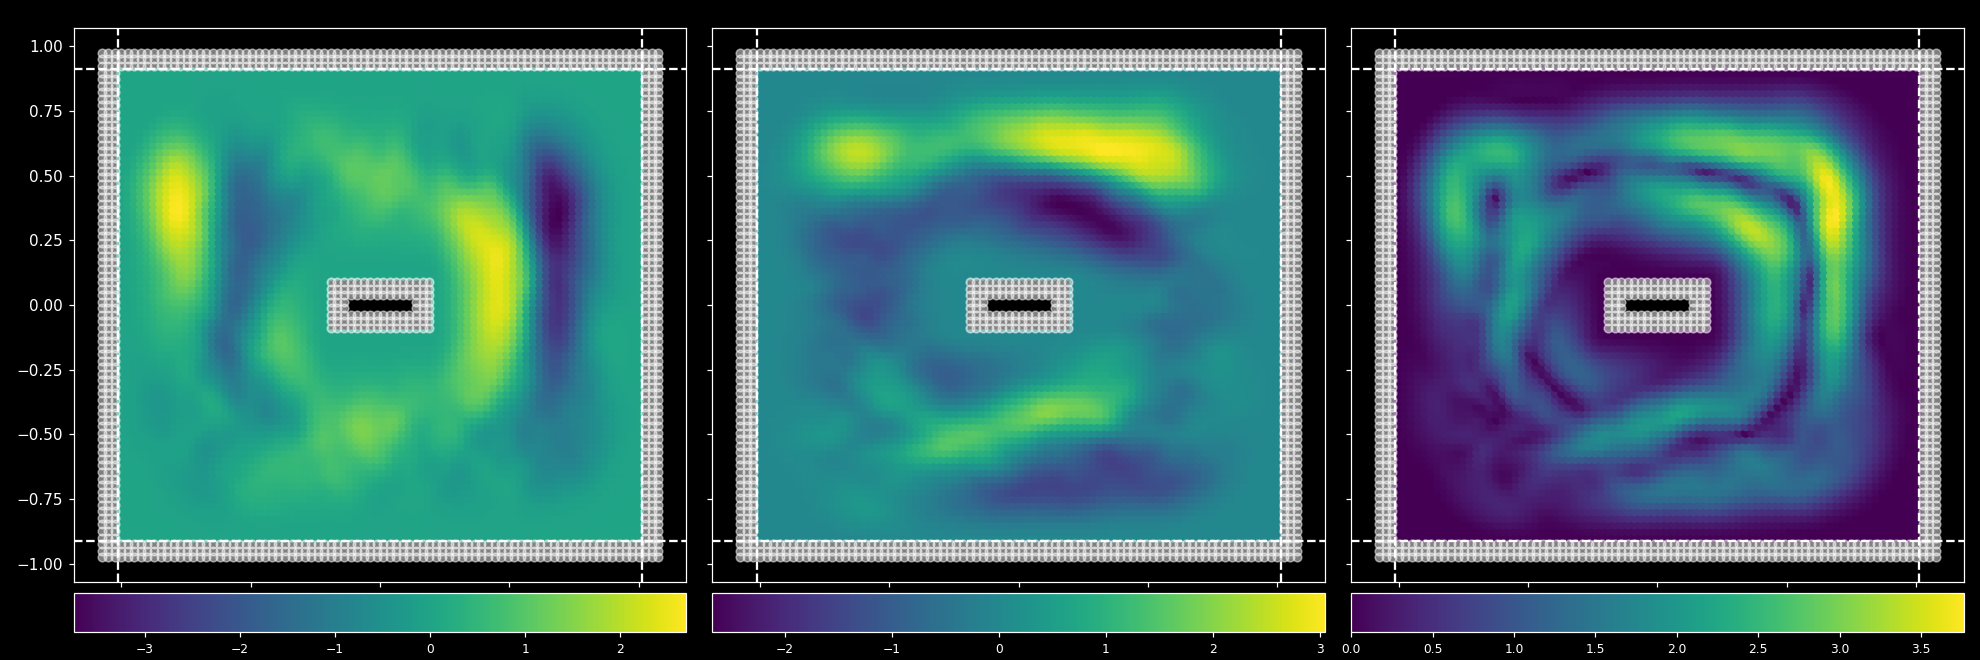

/tmp/ipykernel_261380/3059852447.py:495: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  filtered = filterPotential(torch.tensor(filtered).flatten(), torch.tensor(polySDF).flatten(), d0 = boundary).numpy().reshape(noise.shape)


Number of fluid particles:  5632
Min/Max/Avg velocity:  0.0 3.7605421651357815 0.9146501343690872
Number of boundary particles (Domain):  948
Number of boundary particles (Center):  108
Number of particles:  6688


In [88]:


rows = 1
fig, axis = plt.subplots(rows, 3, figsize=(18,rows * 6), sharex = True, sharey = True, squeeze = False)
# fig, axis = plt.subplots(2, 3, figsize=(18,12), sharex = True, sharey = True, squeeze = False)
for i in range(rows):
    s = 32 / 2**i
    ptcls, vel, domainPtcls, domainGhostPtcls, domainSDF, domainSDFDer, centerPtcls, centerGhostPtcls, centerSDF, centerSDFDer, minDomain, minCenter,xx,yy,potential = genParticles(nd = np.array([8,4]), nb = np.array([32,32]), border = border, n = n, res = res, \
    octaves = octaves, lacunarity = lacunarity, persistance = persistance, seed = seed, boundary = boundaryWidth, dh = 1e-3)

    print('Number of fluid particles: ', ptcls.shape[0])
    print('Min/Max/Avg velocity: ', np.min(np.linalg.norm(vel, axis=1)), np.max(np.linalg.norm(vel, axis=1)), np.mean(np.linalg.norm(vel, axis=1)))
    print('Number of boundary particles (Domain): ', domainPtcls.shape[0])
    print('Number of boundary particles (Center): ', centerPtcls.shape[0])
    print('Number of particles: ', ptcls.shape[0] + domainPtcls.shape[0] + centerPtcls.shape[0])

    scatterPlot(ptcls[:,0], ptcls[:,1], vel[:,0], axis[i,0], fig, s = s)
    scatterPlot(ptcls[:,0], ptcls[:,1], vel[:,1], axis[i,1], fig, s = s)
    scatterPlot(ptcls[:,0], ptcls[:,1], np.linalg.norm(vel, axis=1), axis[i,2], fig, s = s)
    axis[i,0].scatter(np.hstack((domainPtcls[:,0], centerPtcls[:,0])), np.hstack((domainPtcls[:,1], centerPtcls[:,1])), c = 'white',s = s,alpha=0.5)
    axis[i,1].scatter(np.hstack((domainPtcls[:,0], centerPtcls[:,0])), np.hstack((domainPtcls[:,1], centerPtcls[:,1])), c = 'white',s = s,alpha=0.5)
    axis[i,2].scatter(np.hstack((domainPtcls[:,0], centerPtcls[:,0])), np.hstack((domainPtcls[:,1], centerPtcls[:,1])), c = 'white',s = s,alpha=0.5)

# scatterPlot(np.hstack((domainPtcls[:,0], centerPtcls[:,0])), np.hstack((domainPtcls[:,1], centerPtcls[:,1])), np.hstack((domainSDF, centerSDF)), axis[1,0], fig, s = s)
# scatterPlot(np.hstack((domainPtcls[:,0], centerPtcls[:,0])), np.hstack((domainPtcls[:,1], centerPtcls[:,1])), np.hstack((domainSDFDer[:,0], centerSDFDer[:,0])), axis[1,1], fig, s = s)
# scatterPlot(np.hstack((domainPtcls[:,0], centerPtcls[:,0])), np.hstack((domainPtcls[:,1], centerPtcls[:,1])), np.hstack((domainSDFDer[:,0], centerSDFDer[:,0])), axis[1,2], fig, s = s)
# axis[1,0].scatter(ptcls[:,0], ptcls[:,1], c ='white', s = s,alpha=0.5)
# axis[1,1].scatter(ptcls[:,0], ptcls[:,1], c ='white', s = s,alpha=0.5)
# axis[1,2].scatter(ptcls[:,0], ptcls[:,1], c ='white', s = s,alpha=0.5)

for axx in axis:
    for ax in axx:
        ax.axvline(minDomain[0], ls = '--')
        ax.axvline(-minDomain[0], ls = '--')
        ax.axhline(minDomain[1], ls = '--')
        ax.axhline(-minDomain[1], ls = '--')

fig.tight_layout()

<IPython.core.display.Javascript object>


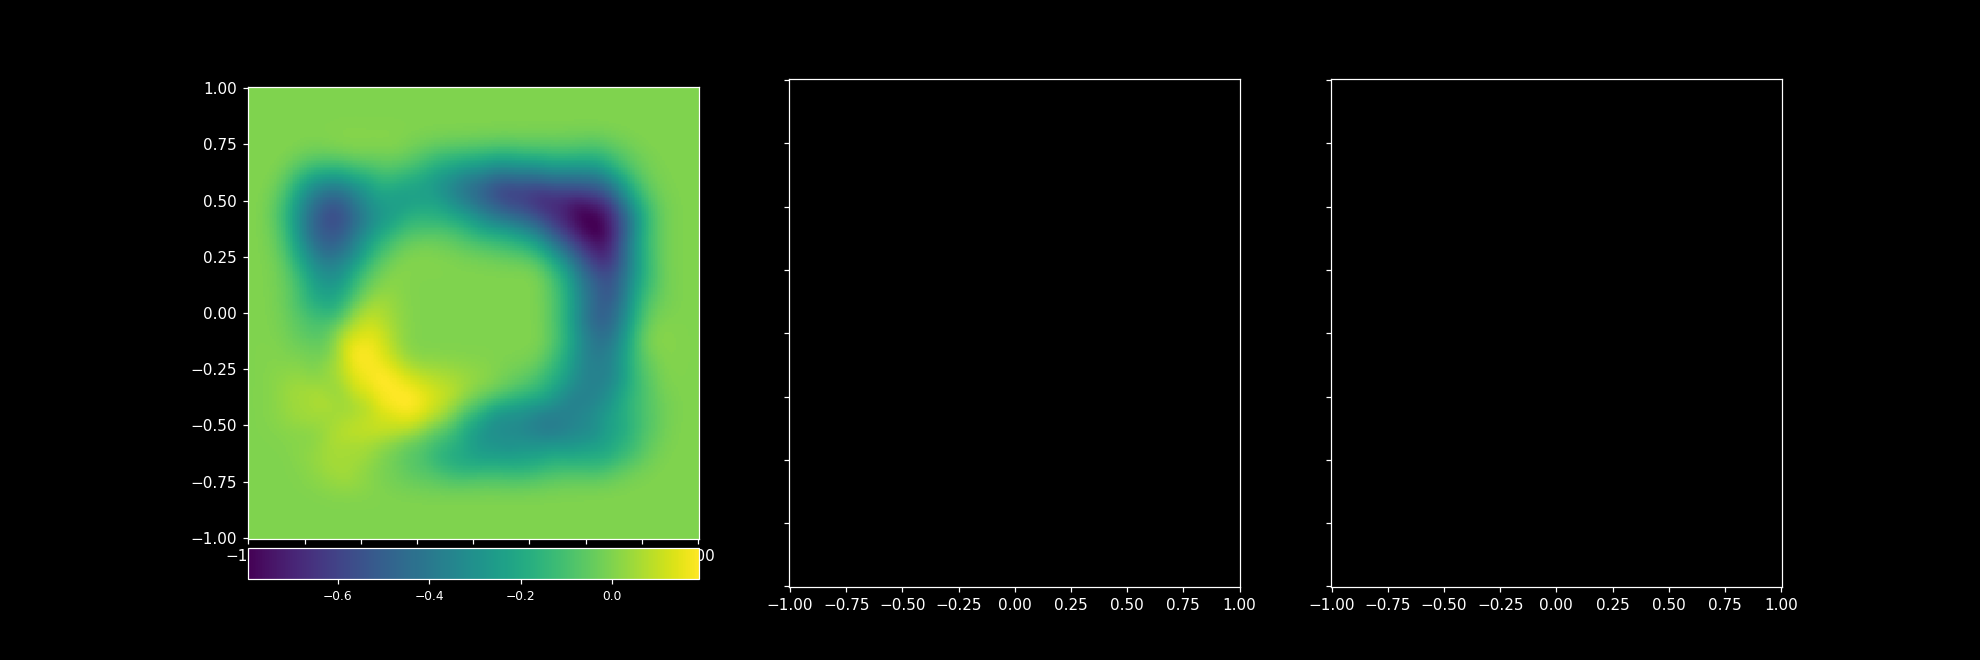

In [89]:

fig, axis = plt.subplots(1, 3, figsize=(18,6), sharex = True, sharey = True, squeeze = False)

plotMesh(xx,yy,potential, axis[0,0], fig)
# axis[0,0].pcolormesh(xx,yy,filtered)

<IPython.core.display.Javascript object>


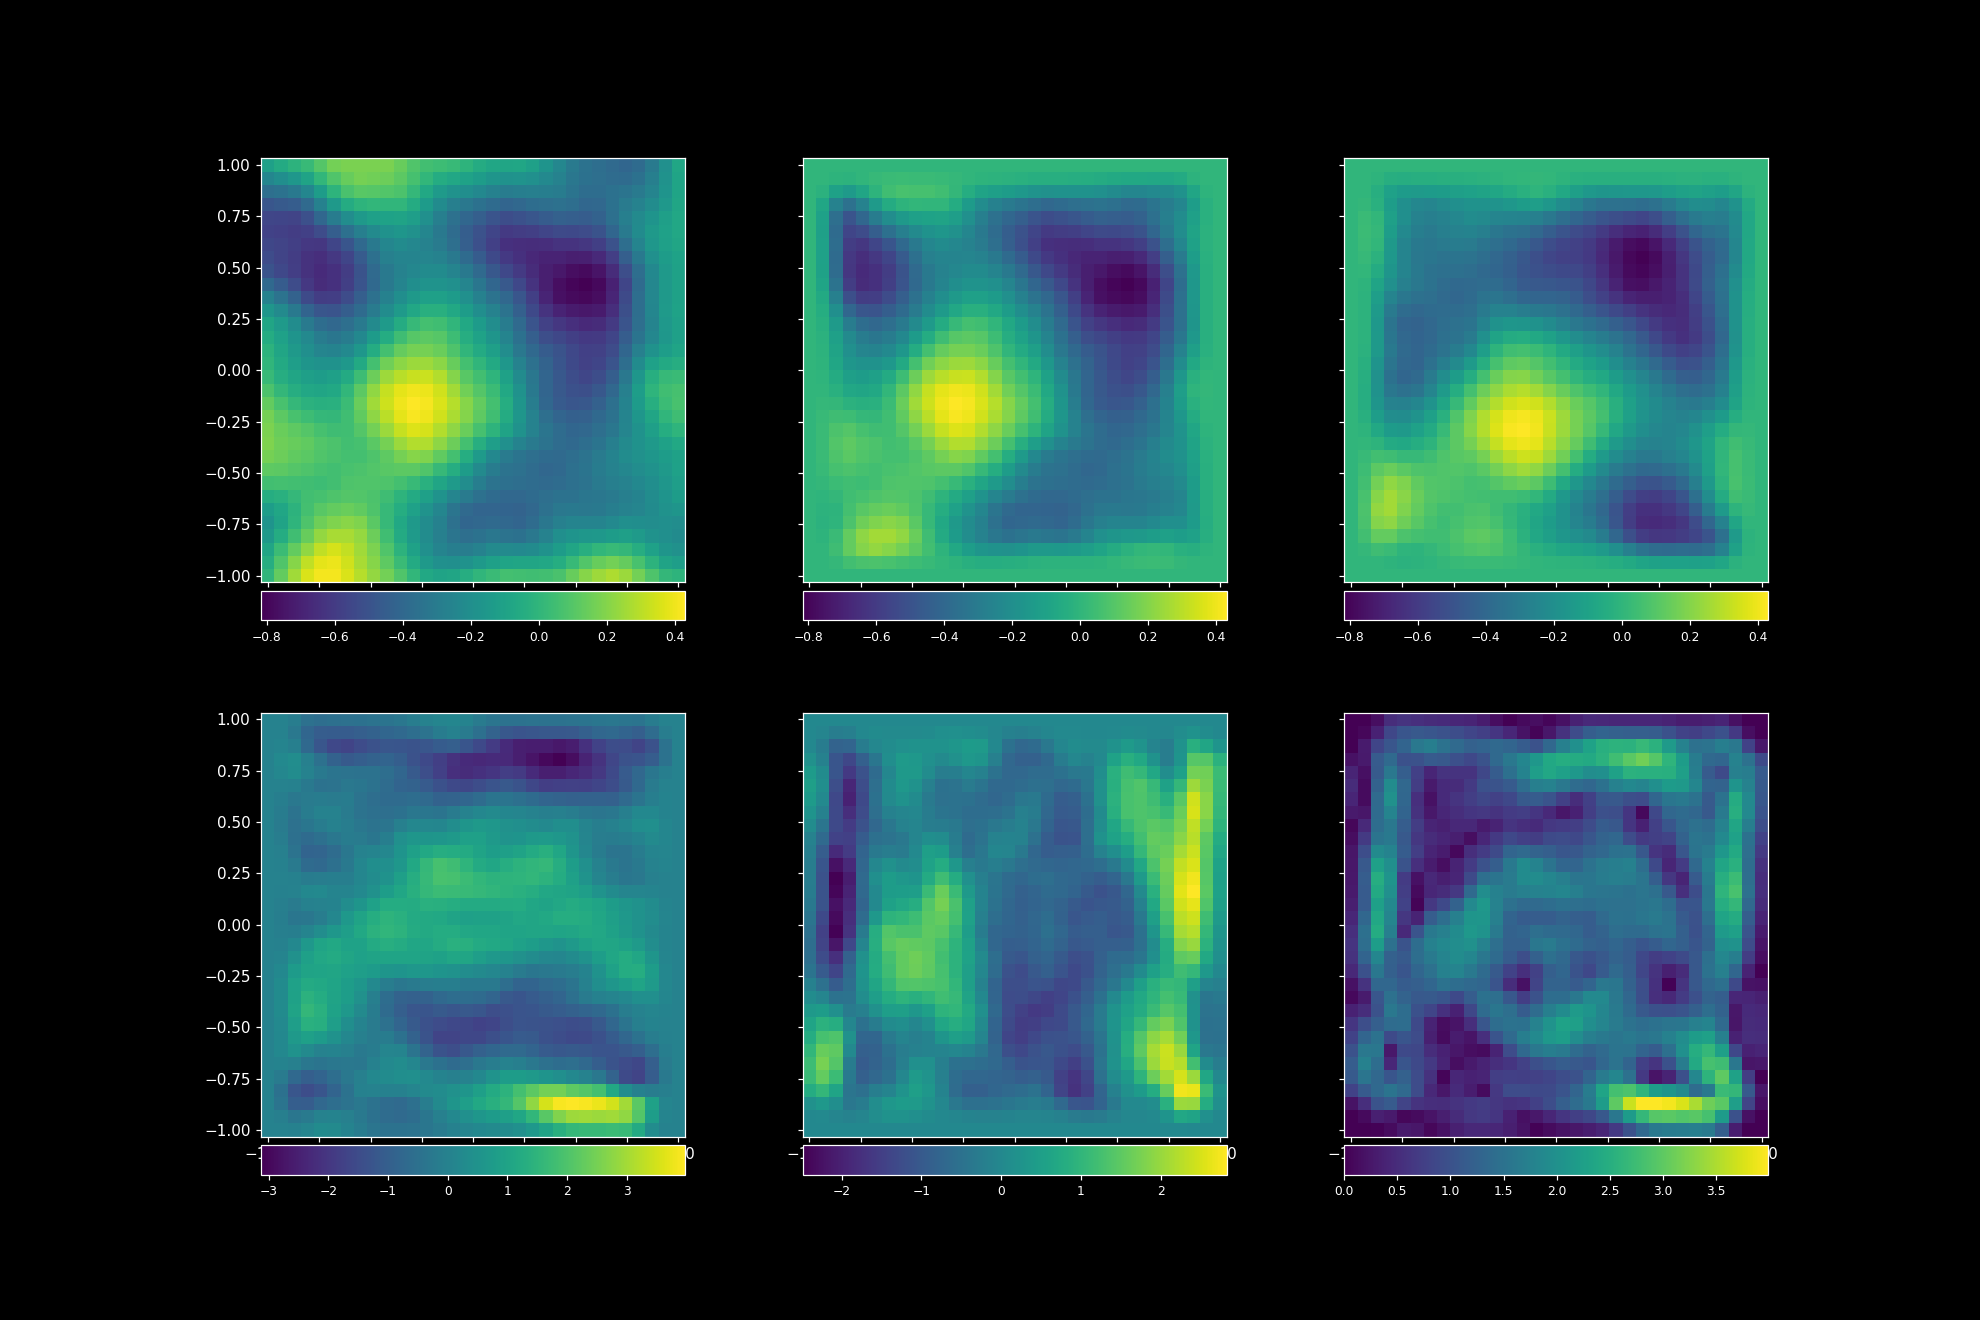

In [12]:
ptcls, bdyPtcls, minDomain, minCenter = generateParticles(0, 32, border = 3)

#     dh = 1e-3

boundary = 0.25
n = 256
dh = 1e-3

c = -minCenter
domainBoundary = np.array([[minDomain + boundary,minDomain + boundary],[-minDomain - boundary,minDomain + boundary], [-minDomain - boundary,-minDomain - boundary],[minDomain + boundary,-minDomain - boundary],[minDomain + boundary,minDomain + boundary]])
centerBoundary = np.array([[-c,-c],[c,-c],[c,c],[-c,c],[-c,-c]])

_, _, polySDF, polySDFGrad = buildSDF(centerBoundary, n = 32, dh = dh)
_, _, domainSDF, domainSDFGrad = buildSDF(domainBoundary, n = 32, dh = dh)
# _, _, domainSDF, domainSDFGrad = buildSDF(np.array([[-1.0 ,-1 ],[1 ,-1 ],\
#                                                     [1 ,1 ],[-1 ,1 ],[-1 ,-1 ]]), n = 256, dh = dh)

# poly, shape = buildPolygon()
# xx, yy, polySDF, polySDFGrad = buildSDF(poly, n = 256)
s = (- domainSDF + boundary).numpy()
s = s.reshape(polySDF.shape)
# s = - domainSDF



xx, yy, noise = createPotentialField(n = 32, res = res, octaves = octaves, lacunarity = lacunarity, persistance = persistance, seed = seed)
filtered = noise

filtered = filterPotential(torch.tensor(filtered).flatten(), torch.tensor(s).flatten(), d0 = boundary ).numpy().reshape(noise.shape)
# if nd > 0:
#     filtered = filterPotential(torch.tensor(filtered).flatten(), torch.tensor(polySDF).flatten(), d0 = boundary).numpy().reshape(noise.shape)
#     filtered[polySDF.reshape(noise.shape) < 0] = 0

x = np.linspace(-1,1,32)
y = np.linspace(-1,1,32)
f = interpolate.RegularGridInterpolator((x, y), filtered, bounds_error = False, fill_value = None, method = 'linear')

velocityField, xx, yy, potential = createVelocityField(f, n = 32)  
#     print(filtered)

fig, axis = plt.subplots(2, 3, figsize=(18,12), sharex = True, sharey = True, squeeze = False)

plotMesh(xx,yy,noise, axis[0,0], fig)
plotMesh(xx,yy,filtered, axis[0,1], fig)
plotMesh(xx,yy,potential, axis[0,2], fig)
plotMesh(xx,yy,velocityField[:,:,0], axis[1,0], fig)
plotMesh(xx,yy,velocityField[:,:,1], axis[1,1], fig)
plotMesh(xx,yy,np.linalg.norm(velocityField, axis = 2), axis[1,2], fig)
# axis[0,0].pcolormesh(xx,yy,filtered)

<IPython.core.display.Javascript object>


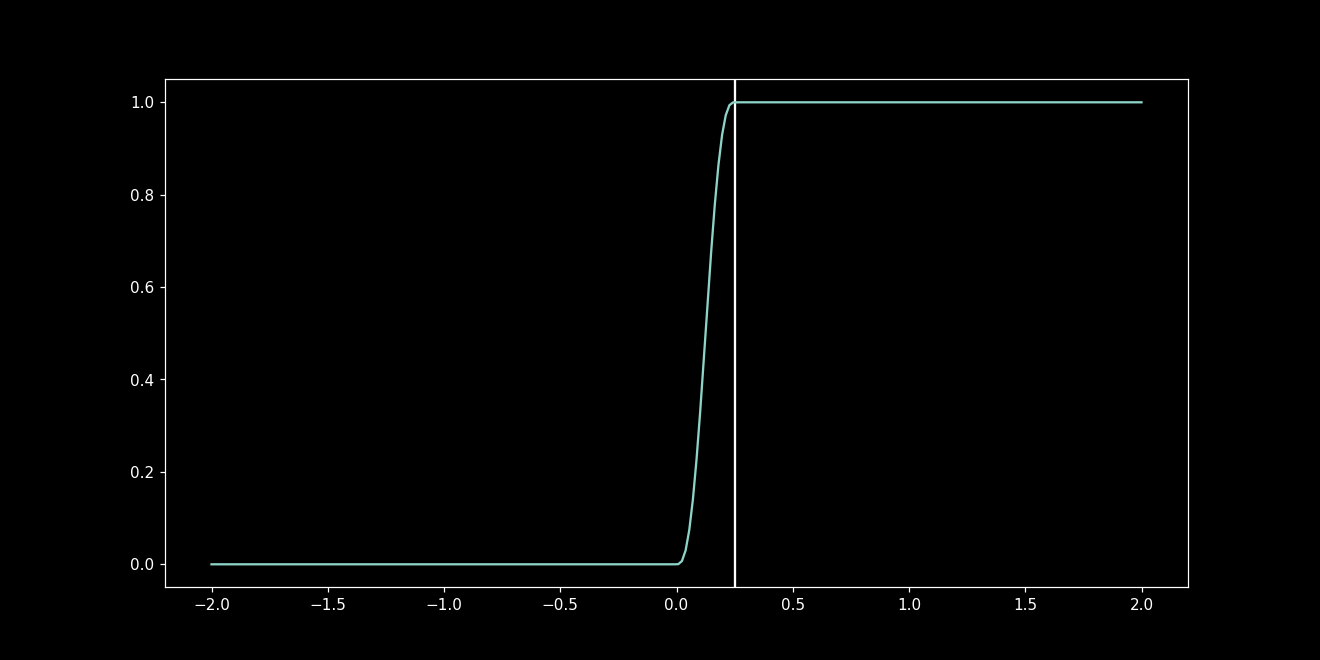

In [13]:

fig, axis = plt.subplots(1, 1, figsize=(12, 6), sharex = True, sharey = True, squeeze = False)
points = np.linspace(-2,2,256)
d0 = 0.25
axis[0,0].axvline(d0)

r = points / d0 / 0.5 - 1
#     ramped = r * r * (3 - 2 * r)
ramped = 15/8 * r - 10/8 * r**3 + 3/8 * r**5
#     ramped = r
ramped[r >= 1] = 1
ramped[r <= -1] = -1
# ramped[r <= 0] = 0
# funValues = 

axis[0,0].plot(points, ramped/2 + 0.5)

<IPython.core.display.Javascript object>


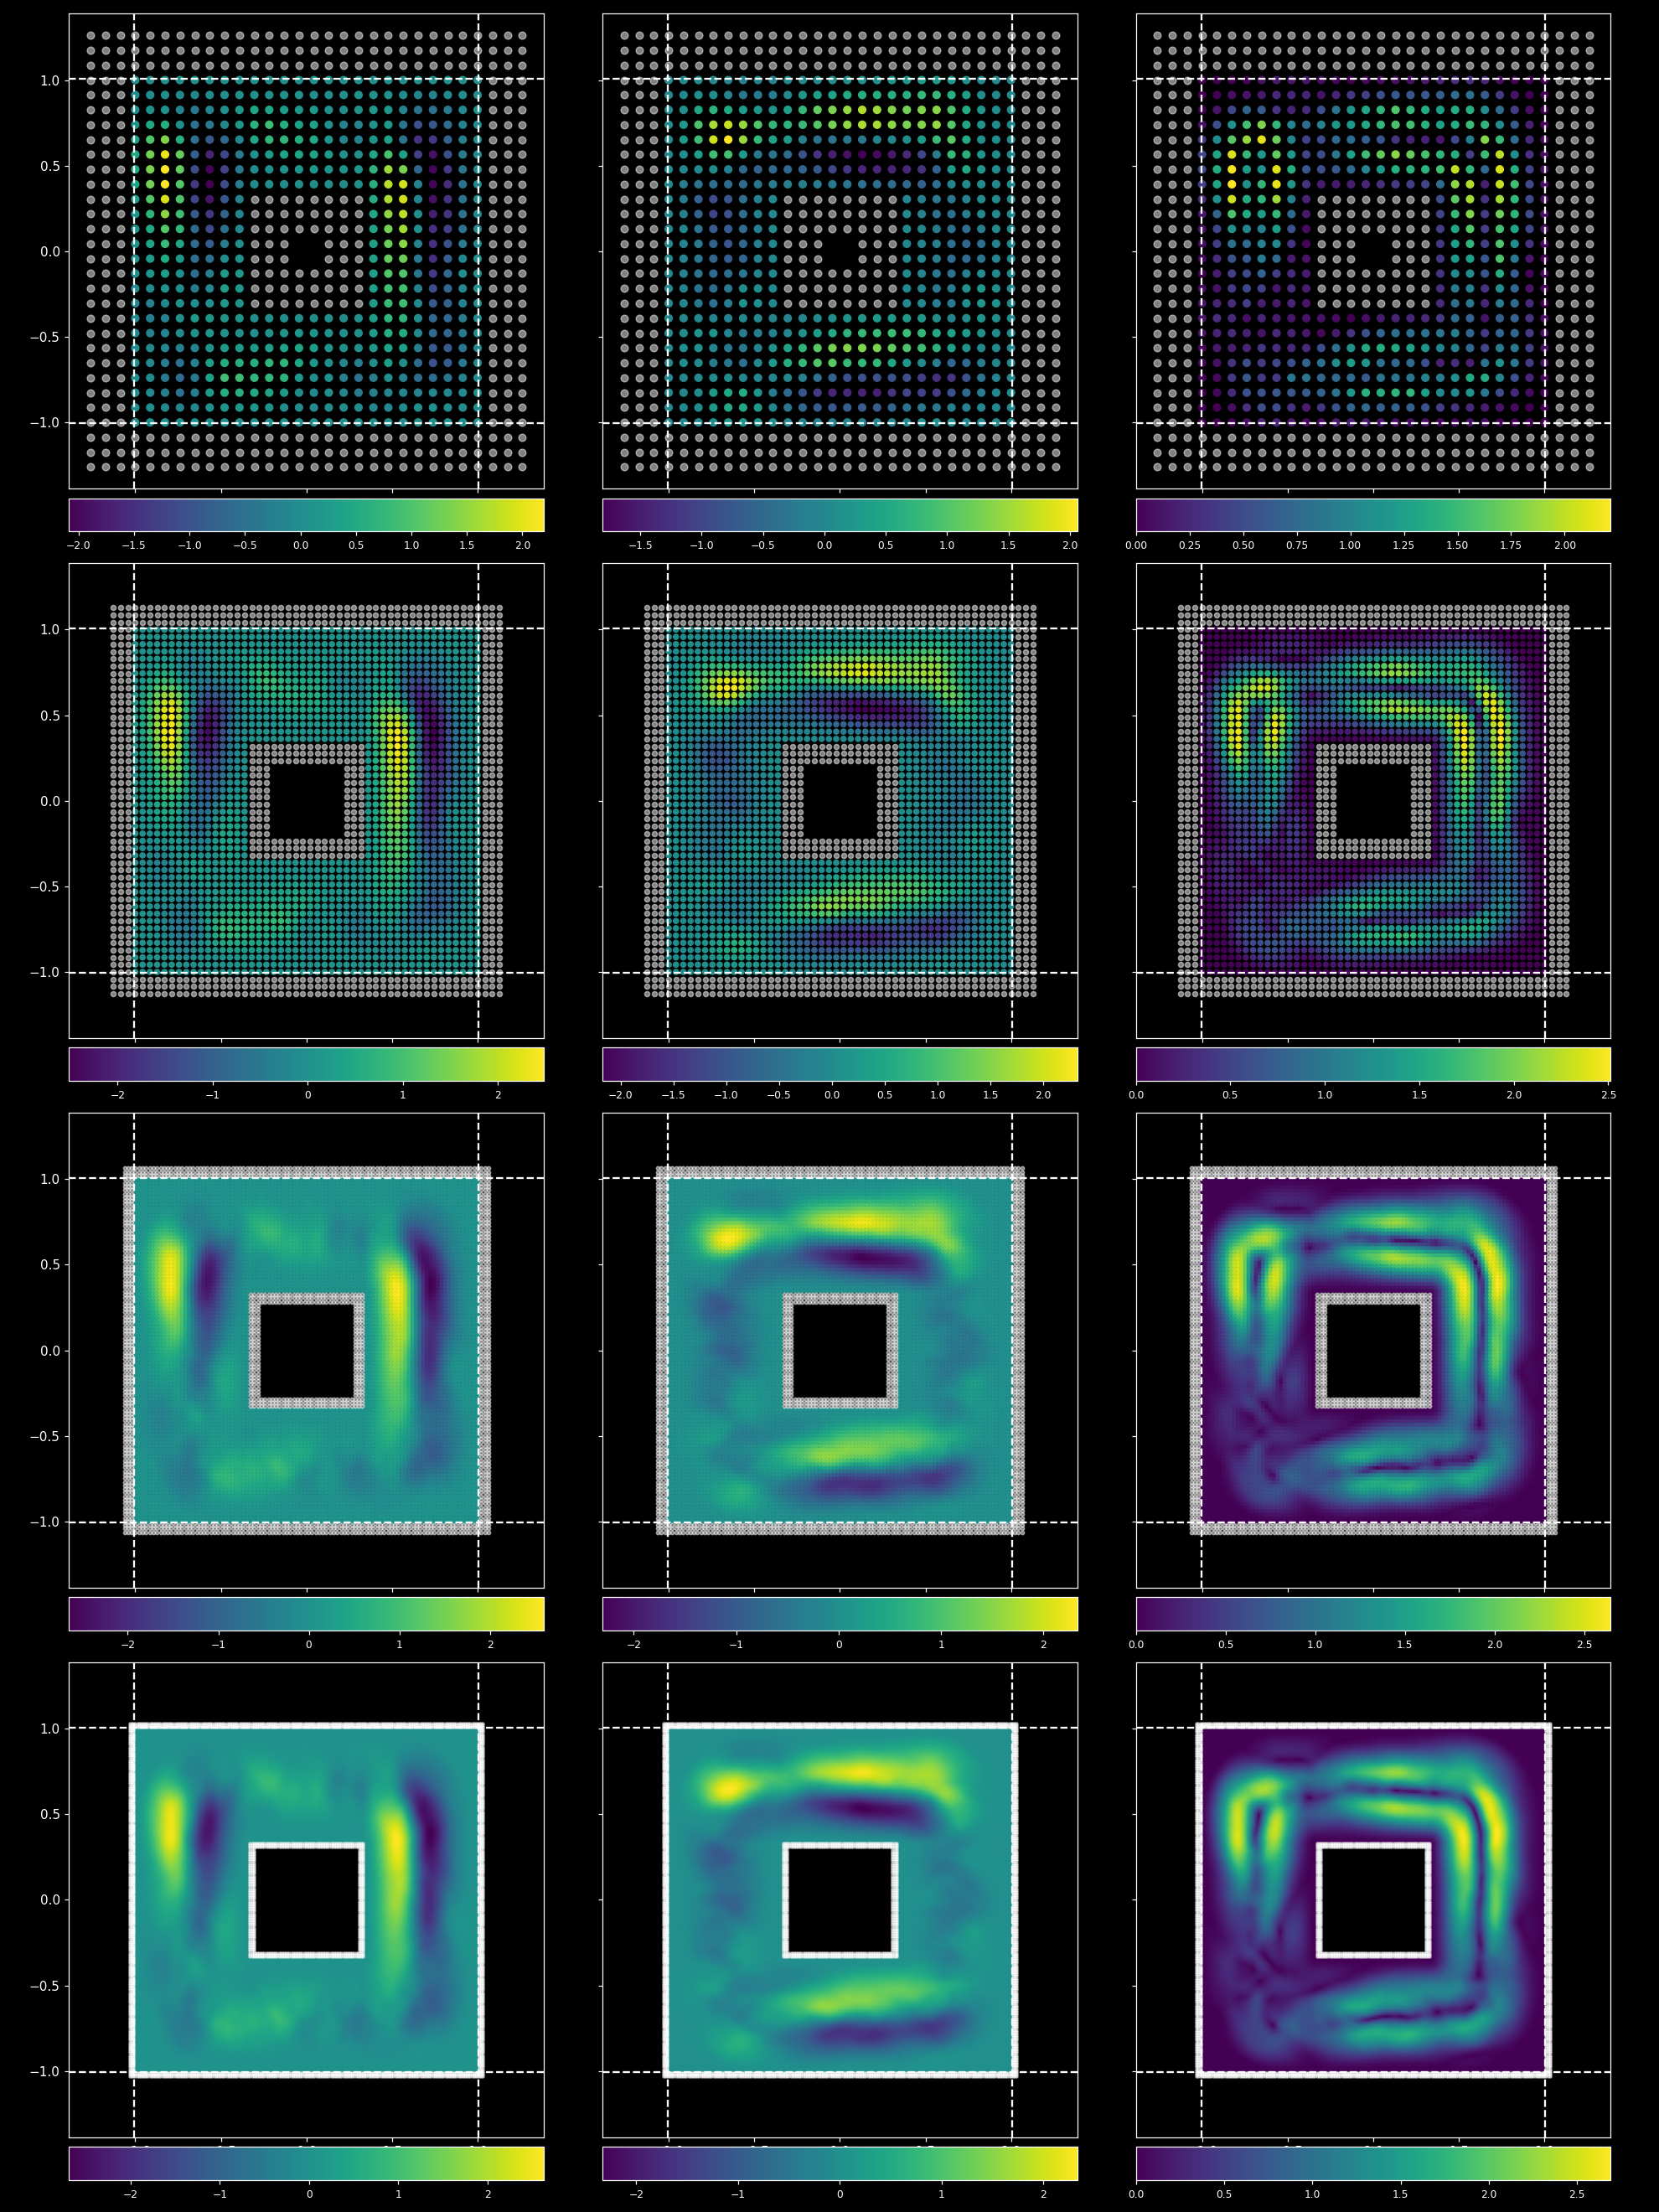

/tmp/ipykernel_261380/4234376958.py:479: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  filtered = filterPotential(torch.tensor(filtered).flatten(), torch.tensor(polySDF).flatten(), d0 = boundary).numpy().reshape(noise.shape)


Number of fluid particles:  512
Min/Max/Avg velocity:  0.0 2.2144201991825048 0.6465092811932853
Number of boundary particles (Domain):  324
Number of boundary particles (Center):  60
Number of particles:  896
Number of fluid particles:  2048
Min/Max/Avg velocity:  0.0 2.512616567579728 0.6882718504517849
Number of boundary particles (Domain):  612
Number of boundary particles (Center):  156
Number of particles:  2816
Number of fluid particles:  8192
Min/Max/Avg velocity:  0.0 2.6480048142708323 0.6966386011905767
Number of boundary particles (Domain):  1188
Number of boundary particles (Center):  348
Number of particles:  9728
Number of fluid particles:  32768
Min/Max/Avg velocity:  0.0 2.6899608290857335 0.697360658931346
Number of boundary particles (Domain):  2340
Number of boundary particles (Center):  732
Number of particles:  35840


In [14]:


rows = 4
fig, axis = plt.subplots(rows, 3, figsize=(18,rows * 6), sharex = True, sharey = True, squeeze = False)
# fig, axis = plt.subplots(2, 3, figsize=(18,12), sharex = True, sharey = True, squeeze = False)
for i in range(4):
    s = 32 / 2**i
    ptcls, vel, domainPtcls, domainGhostPtcls, domainSDF, domainSDFDer, centerPtcls, centerGhostPtcls, centerSDF, centerSDFDer, minDomain, minCenter,_,_,_ = genParticles(nd = nd_base * 2**i, nb = nb_base * 2**i, border = border, n = n, res = res, octaves = octaves, lacunarity = lacunarity, persistance = persistance, seed = seed, boundary = boundaryWidth, dh = 1e-3)

    print('Number of fluid particles: ', ptcls.shape[0])
    print('Min/Max/Avg velocity: ', np.min(np.linalg.norm(vel, axis=1)), np.max(np.linalg.norm(vel, axis=1)), np.mean(np.linalg.norm(vel, axis=1)))
    print('Number of boundary particles (Domain): ', domainPtcls.shape[0])
    print('Number of boundary particles (Center): ', centerPtcls.shape[0])
    print('Number of particles: ', ptcls.shape[0] + domainPtcls.shape[0] + centerPtcls.shape[0])

    scatterPlot(ptcls[:,0], ptcls[:,1], vel[:,0], axis[i,0], fig, s = s)
    scatterPlot(ptcls[:,0], ptcls[:,1], vel[:,1], axis[i,1], fig, s = s)
    scatterPlot(ptcls[:,0], ptcls[:,1], np.linalg.norm(vel, axis=1), axis[i,2], fig, s = s)
    axis[i,0].scatter(np.hstack((domainPtcls[:,0], centerPtcls[:,0])), np.hstack((domainPtcls[:,1], centerPtcls[:,1])), c = 'white',s = s,alpha=0.5)
    axis[i,1].scatter(np.hstack((domainPtcls[:,0], centerPtcls[:,0])), np.hstack((domainPtcls[:,1], centerPtcls[:,1])), c = 'white',s = s,alpha=0.5)
    axis[i,2].scatter(np.hstack((domainPtcls[:,0], centerPtcls[:,0])), np.hstack((domainPtcls[:,1], centerPtcls[:,1])), c = 'white',s = s,alpha=0.5)

# scatterPlot(np.hstack((domainPtcls[:,0], centerPtcls[:,0])), np.hstack((domainPtcls[:,1], centerPtcls[:,1])), np.hstack((domainSDF, centerSDF)), axis[1,0], fig, s = s)
# scatterPlot(np.hstack((domainPtcls[:,0], centerPtcls[:,0])), np.hstack((domainPtcls[:,1], centerPtcls[:,1])), np.hstack((domainSDFDer[:,0], centerSDFDer[:,0])), axis[1,1], fig, s = s)
# scatterPlot(np.hstack((domainPtcls[:,0], centerPtcls[:,0])), np.hstack((domainPtcls[:,1], centerPtcls[:,1])), np.hstack((domainSDFDer[:,0], centerSDFDer[:,0])), axis[1,2], fig, s = s)
# axis[1,0].scatter(ptcls[:,0], ptcls[:,1], c ='white', s = s,alpha=0.5)
# axis[1,1].scatter(ptcls[:,0], ptcls[:,1], c ='white', s = s,alpha=0.5)
# axis[1,2].scatter(ptcls[:,0], ptcls[:,1], c ='white', s = s,alpha=0.5)

for axx in axis:
    for ax in axx:
        ax.axvline(minDomain, ls = '--')
        ax.axvline(-minDomain, ls = '--')
        ax.axhline(minDomain, ls = '--')
        ax.axhline(-minDomain, ls = '--')

fig.tight_layout()

In [15]:
ptcls, vel, domainPtcls, domainGhostPtcls, domainSDF, domainSDFDer, centerPtcls, centerGhostPtcls, centerSDF, centerSDFDer, minDomain, minCente

NameError: name 'minCente' is not defined

In [16]:
nd = 0
nb = 16
ptcls, vel, domainPtcls, domainGhostPtcls, domainSDF, domainSDFDer, centerPtcls, centerGhostPtcls, centerSDF, centerSDFDer, minDomain, minCenter,xx,yy, noiseField = genParticles(nd = nd, nb = nb, border = border, n = n, res = res, octaves = octaves, lacunarity = lacunarity, persistance = persistance, seed = seed, boundary = boundaryWidth, dh = 1e-3)
dx = 2 / (2 * (nd + nb) - 1)
area = dx**2
r = np.sqrt(area/ np.pi)
ropt =  minimize(lambda r: evalRadius(r[0], dx, torch.float32, 'cpu'), r, method="nelder-mead").x[0]        

r = ropt
area = np.pi * r**2
support = np.single(np.sqrt(area / np.pi * 20))

allPtcls = torch.tensor(np.vstack((ptcls, domainPtcls, centerPtcls)))
allVels = torch.tensor( np.vstack((vel, np.zeros_like(domainPtcls), np.zeros_like(centerPtcls))))


In [17]:
row, col = radius(allPtcls, allPtcls, \
                  support, max_num_neighbors = 256)
fluidNeighbors = torch.stack([row, col], dim = 0)

i = fluidNeighbors[1]
j = fluidNeighbors[0]

fluidDistances = (allPtcls[fluidNeighbors[1]] - allPtcls[fluidNeighbors[0]])
fluidRadialDistances = torch.linalg.norm(fluidDistances,axis=1)

fluidRadialDistances /= support
rho = scatter(\
        kernel(fluidRadialDistances, support) * area, \
        fluidNeighbors[1], dim=0, dim_size=allPtcls.size(0), reduce="add")
#     print(rho)

<IPython.core.display.Javascript object>


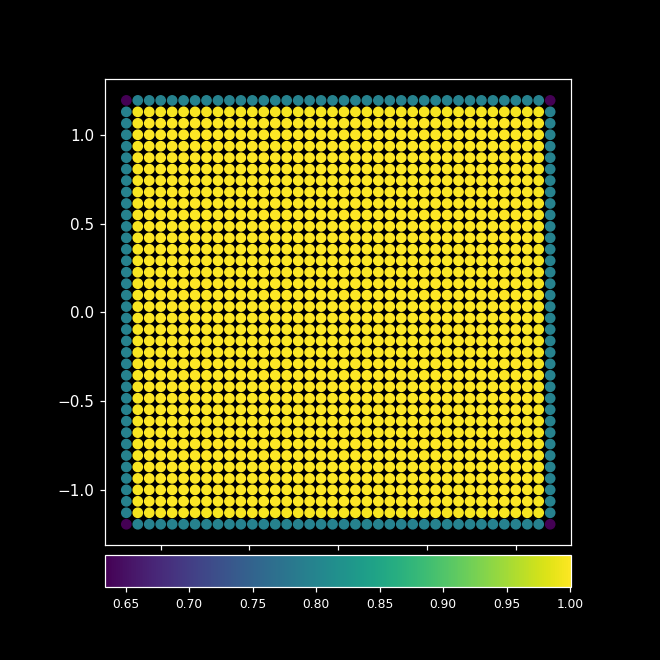

In [18]:
x_ij = allPtcls[i] - allPtcls[j]
dist_ij = torch.linalg.norm(fluidDistances,axis=1)
dir_ij = torch.clone(x_ij)
dir_ij[dist_ij > 1e-5] = x_ij[dist_ij > 1e-5] / dist_ij[dist_ij > 1e-5,None]
dist_ij = dist_ij / support

rho = scatter(kernel(dist_ij, support) * area, i, dim=0, dim_size=allPtcls.size(0), reduce="add")
fig, axis = plt.subplots(1, 1, figsize=(6,6), sharex = True, sharey = True, squeeze = False)
scatterPlot(allPtcls[:,0], allPtcls[:,1], rho, axis[0,0], fig)

<IPython.core.display.Javascript object>


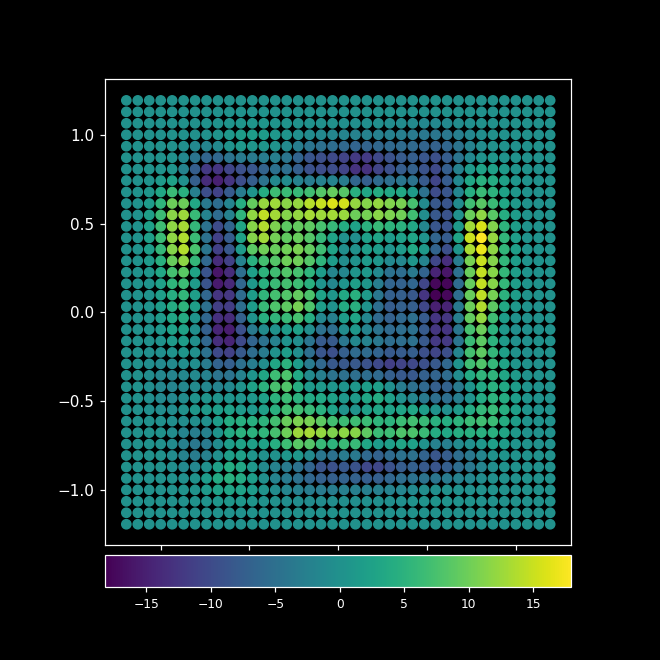

In [19]:
gterm = area / rho[j]  * torch.einsum('nu, nv -> n', allVels[j] - allVels[i], kernelGrad(dist_ij, dir_ij, support))

div = scatter(gterm, i, dim=0, dim_size=allPtcls.size(0), reduce="add")
fig, axis = plt.subplots(1, 1, figsize=(6,6), sharex = True, sharey = True, squeeze = False)
scatterPlot(allPtcls[:,0], allPtcls[:,1], div, axis[0,0], fig)

In [135]:

def filterNoise(filtered, minDomain, minCenter, boundary, nb, nd):
    c = -minCenter
    domainBoundary = np.array([[minDomain[0] + boundary,minDomain[1] + boundary],[-minDomain[0] - boundary,minDomain[1] + boundary], [-minDomain[0] - boundary,-minDomain[1] - boundary],[minDomain[0] + boundary,-minDomain[1] - boundary],[minDomain[0] + boundary,minDomain[1] + boundary]])
    centerBoundary = np.array([[-c[0],-c[1]],[c[0],-c[1]],[c[0],c[1]],[-c[0],c[1]],[-c[0],-c[1]]])

    _, _, polySDF, polySDFGrad = buildSDF(centerBoundary, n = n, dh = dh)
    _, _, domainSDF, domainSDFGrad = buildSDF(domainBoundary, n = n, dh = dh)
    s = (- domainSDF + boundary).numpy()
    s = s.reshape(polySDF.shape)
#     s = s.transpose()
    
    xx, yy, noise = createPotentialField(n = n, res = res, octaves = octaves, lacunarity = lacunarity, persistance = persistance, seed = seed)
    filtered = noise
    
    filtered = filterPotential((filtered).flatten(), torch.tensor(s).flatten(), d0 = boundary ).numpy().reshape(noise.shape)
    if np.any(nd > 0):
        filtered = filterPotential((filtered).flatten(), (polySDF).flatten(), d0 = boundary).numpy().reshape(noise.shape)
        filtered[polySDF.reshape(noise.shape) < 0] = 0
    return filtered


In [136]:

nd = 16
nb = 32
nd = np.array([nd,nd//2])
nb = np.array([nb,nb//2])
ptcls, vel, domainPtcls, domainGhostPtcls, domainSDF, domainSDFDer, centerPtcls, centerGhostPtcls, centerSDF, centerSDFDer, minDomain, minCenter,xx,yy, noiseField = genParticles(nd = nd, nb = nb, border = border, n = n, res = res, octaves = octaves, lacunarity = lacunarity, persistance = persistance, seed = seed, boundary = boundaryWidth, dh = 1e-3)
dx = 2 / (2 * np.max((nd + nb)) - 1)
area = dx**2
r = np.sqrt(area/ np.pi)
ropt =  minimize(lambda r: evalRadius(r[0], dx, torch.float32, 'cpu'), r, method="nelder-mead").x[0]        

r = ropt
area = np.pi * r**2
support = np.single(np.sqrt(area / np.pi * 20))

allPtcls = torch.tensor(np.vstack((ptcls, domainPtcls, centerPtcls)))
allVels = torch.tensor( np.vstack((vel, np.zeros_like(domainPtcls), np.zeros_like(centerPtcls))))
    
xx, yy, noise = createPotentialField(n = n, res = 2, octaves = 4, lacunarity = lacunarity, persistance = persistance, seed = seed)
filtered = filterNoise(noise, minDomain, minCenter, boundary, nb, nd)
noiseSampler = interpolate.RegularGridInterpolator((np.linspace(-1,1,n), np.linspace(-1,1,n)), filtered, bounds_error = False, fill_value = None, method = 'linear')

velocities, rho, potential, div = noisifyParticles(noiseSampler, allPtcls, support)

mask = torch.zeros(allPtcls.shape[0])
mask[torch.arange(allPtcls.shape[0]) < len(ptcls)] = 1
mask = mask == 1
# velocities[mask] = torch.tensor(vel)
def scatterPlot(x,y,z, axis, fig, s = None):
    im = axis.scatter(x,y,c = z, s = s)
    axis.axis('equal')
    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("bottom", size="7%", pad="8%")
    cbar = fig.colorbar(im, cax=cax1,orientation='horizontal')
    cbar.ax.tick_params(labelsize=8)
    
fig, axis = plt.subplots(1, 5, figsize=(24,6), sharex = True, sharey = True, squeeze = False)
scatterPlot(allPtcls[mask,0], allPtcls[mask,1], rho[mask], axis[0,0], fig)
scatterPlot(allPtcls[mask,0], allPtcls[mask,1], potential[mask], axis[0,1], fig)
scatterPlot(allPtcls[mask,0], allPtcls[mask,1], velocities[mask,0], axis[0,2], fig)
scatterPlot(allPtcls[mask,0], allPtcls[mask,1], velocities[mask,1], axis[0,3], fig)
scatterPlot(allPtcls[mask,0], allPtcls[mask,1], div[mask], axis[0,4], fig)
axis[0,0].scatter(domainPtcls[:,0], domainPtcls[:,1], alpha = 0.5)
axis[0,1].scatter(domainPtcls[:,0], domainPtcls[:,1], alpha = 0.5)
axis[0,2].scatter(domainPtcls[:,0], domainPtcls[:,1], alpha = 0.5)
axis[0,3].scatter(domainPtcls[:,0], domainPtcls[:,1], alpha = 0.5)
axis[0,4].scatter(domainPtcls[:,0], domainPtcls[:,1], alpha = 0.5)

axis[0,0].set_title('Density')
axis[0,1].set_title('Potential')
axis[0,2].set_title('velocity.x')
axis[0,3].set_title('velocity.y')
axis[0,4].set_title('divergence')

fig.tight_layout()

/tmp/ipykernel_261380/2810670853.py:495: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  filtered = filterPotential(torch.tensor(filtered).flatten(), torch.tensor(polySDF).flatten(), d0 = boundary).numpy().reshape(noise.shape)


AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

In [22]:
def noisifyParticles(noiseSampler, allPtcls, support):
    row, col = radius(allPtcls, allPtcls, \
                      support, max_num_neighbors = 256)
    fluidNeighbors = torch.stack([row, col], dim = 0)

    i = fluidNeighbors[1]
    j = fluidNeighbors[0]

    fluidDistances = (allPtcls[fluidNeighbors[1]] - allPtcls[fluidNeighbors[0]])
    fluidRadialDistances = torch.linalg.norm(fluidDistances,axis=1)

    fluidRadialDistances /= support
    
    rho = scatter(kernel(dist_ij, support) * area, i, dim=0, dim_size=allPtcls.size(0), reduce="add")
    
    potential = noiseSampler((allPtcls[:,0], allPtcls[:,1]))
    
    gradTerm = (area / rho[j]  *  (potential[j] - potential[i]))[:,None] * kernelGrad(dist_ij, dir_ij, support)
    potentialGradient = scatter(gradTerm, i, dim=0, dim_size=allPtcls.size(0), reduce="add")

    velocities = torch.zeros_like(potentialGradient)
    velocities[:,0] = potentialGradient[:,1]
    velocities[:,1] = -potentialGradient[:,0]
    
    velocityField, xx, yy, potentialField = createVelocityField(noiseSampler, n = n, dh = 2 / (0 + 64) / 2)  
    print(np.transpose(velocityField, axes=[1,0,2]).shape)
    f = interpolate.RegularGridInterpolator((x, y), np.transpose(velocityField, axes=[1,0,2]), bounds_error = False, fill_value = None, method = 'linear')
    potentialGradient = torch.tensor(f((allPtcls[:,0], allPtcls[:,1])))
    velocities[:,0] = -potentialGradient[:,0]
    velocities[:,1] = -potentialGradient[:,1]
#     print(allPtcls.shape)
#     print(velocities.shape)
    
    gterm = area / rho[j]  * torch.einsum('nd, nd -> n', velocities[j] - velocities[i], kernelGrad(dist_ij, dir_ij, support))

    div = scatter(gterm, i, dim=0, dim_size=allPtcls.size(0), reduce="add")
    
    return velocities, rho, potential, div
    
    


def filterNoise(filtered, minDomain, minCenter, boundary, nb, nd):
    c = -minCenter
    domainBoundary = np.array([[minDomain + boundary,minDomain + boundary],[-minDomain - boundary,minDomain + boundary], [-minDomain - boundary,-minDomain - boundary],[minDomain + boundary,-minDomain - boundary],[minDomain + boundary,minDomain + boundary]])
    centerBoundary = np.array([[-c,-c],[c,-c],[c,c],[-c,c],[-c,-c]])

    _, _, polySDF, polySDFGrad = buildSDF(centerBoundary, n = n, dh = dh)
    _, _, domainSDF, domainSDFGrad = buildSDF(domainBoundary, n = n, dh = dh)
    # _, _, domainSDF, domainSDFGrad = buildSDF(np.array([[-1.0 ,-1 ],[1 ,-1 ],\
    #                                                     [1 ,1 ],[-1 ,1 ],[-1 ,-1 ]]), n = 256, dh = dh)

    # poly, shape = buildPolygon()
    # xx, yy, polySDF, polySDFGrad = buildSDF(poly, n = 256)
    s = (- domainSDF + boundary).numpy()
    s = s.reshape(polySDF.shape)
    # s = - domainSDF



    xx, yy, noise = createPotentialField(n = n, res = res, octaves = octaves, lacunarity = lacunarity, persistance = persistance, seed = seed)
    filtered = noise
    
    filtered = filterPotential(torch.tensor(filtered).flatten(), torch.tensor(s).flatten(), d0 = boundary ).numpy().reshape(noise.shape)
    if nd > 0:
        filtered = filterPotential(torch.tensor(filtered).flatten(), torch.tensor(polySDF).flatten(), d0 = boundary).numpy().reshape(noise.shape)
        filtered[polySDF.reshape(noise.shape) < 0] = 0
    return filtered 
    
xx, yy, noise = createPotentialField(n = n, res = 2, octaves = 4, lacunarity = lacunarity, persistance = persistance, seed = seed)
filtered = filterNoise(noise, minDomain, minCenter, boundary, 32, 0)
noiseSampler = interpolate.RegularGridInterpolator((np.linspace(-1,1,n), np.linspace(-1,1,n)), filtered, bounds_error = False, fill_value = None, method = 'linear')

velocities, rho, potential, div = noisifyParticles(noiseSampler, allPtcls, support)

mask = torch.zeros(allPtcls.shape[0])
mask[torch.arange(allPtcls.shape[0]) < len(ptcls)] = 1
mask = mask == 1

def scatterPlot(x,y,z, axis, fig, s = None):
    im = axis.scatter(x,y,c = z, s = s)
    axis.axis('equal')
    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("bottom", size="7%", pad="8%")
    cbar = fig.colorbar(im, cax=cax1,orientation='horizontal')
    cbar.ax.tick_params(labelsize=8)
    
fig, axis = plt.subplots(1, 5, figsize=(24,6), sharex = True, sharey = True, squeeze = False)
scatterPlot(allPtcls[mask,0], allPtcls[mask,1], rho[mask], axis[0,0], fig)
scatterPlot(allPtcls[mask,0], allPtcls[mask,1], potential[mask], axis[0,1], fig)
scatterPlot(allPtcls[mask,0], allPtcls[mask,1], velocities[mask,0], axis[0,2], fig)
scatterPlot(allPtcls[mask,0], allPtcls[mask,1], velocities[mask,1], axis[0,3], fig)
scatterPlot(allPtcls[mask,0], allPtcls[mask,1], div[mask], axis[0,4], fig)
axis[0,0].scatter(domainPtcls[:,0], domainPtcls[:,1], alpha = 0.5)
axis[0,1].scatter(domainPtcls[:,0], domainPtcls[:,1], alpha = 0.5)
axis[0,2].scatter(domainPtcls[:,0], domainPtcls[:,1], alpha = 0.5)
axis[0,3].scatter(domainPtcls[:,0], domainPtcls[:,1], alpha = 0.5)
axis[0,4].scatter(domainPtcls[:,0], domainPtcls[:,1], alpha = 0.5)

axis[0,0].set_title('Density')
axis[0,1].set_title('Potential')
axis[0,2].set_title('velocity.x')
axis[0,3].set_title('velocity.y')
axis[0,4].set_title('divergence')

fig.tight_layout()

RuntimeError: The expanded size of the tensor (28672) must match the existing size (99840) at non-singleton dimension 0.  Target sizes: [28672].  Tensor sizes: [99840]

In [ ]:
print(torch.std(rho[mask]))

In [23]:
torch.sum(gterm[i == allPtcls.shape[0] / 2])

tensor(0., dtype=torch.float64)

In [24]:
si =  allPtcls.shape[0] // 2
selected = i == si

ij = j[i == si]

gterm = area / rho[ij]  * torch.einsum('nd, nd -> n', velocities[ij] - velocities[i[i == si]], kernelGrad(dist_ij[selected], dir_ij[selected], support))
print(kernelGrad(dist_ij[selected], dir_ij[selected], support))
grads = kernelGrad(dist_ij[selected], dir_ij[selected], support)
g = torch.zeros_like(grads)
g[:,0] = grads[:,1]
g[:,1] = grads[:,0]
# grads = g

s = 0
for ni, neigh in enumerate(ij):
    print(si, neigh, rho[neigh], ' ', velocities[neigh], ' => ', velocities[neigh] - velocities[si], ' x ', grads[ni] ,' -> ', area / rho[neigh] * torch.einsum('n, n', velocities[neigh] - velocities[si], grads[ni]))
    s +=  area / rho[neigh] * torch.einsum('n, n', velocities[neigh] - velocities[si], grads[ni])
print(torch.sum(gterm))
print(s)

tensor([], size=(0, 2), dtype=torch.float64)
tensor(0., dtype=torch.float64)
0


<IPython.core.display.Javascript object>


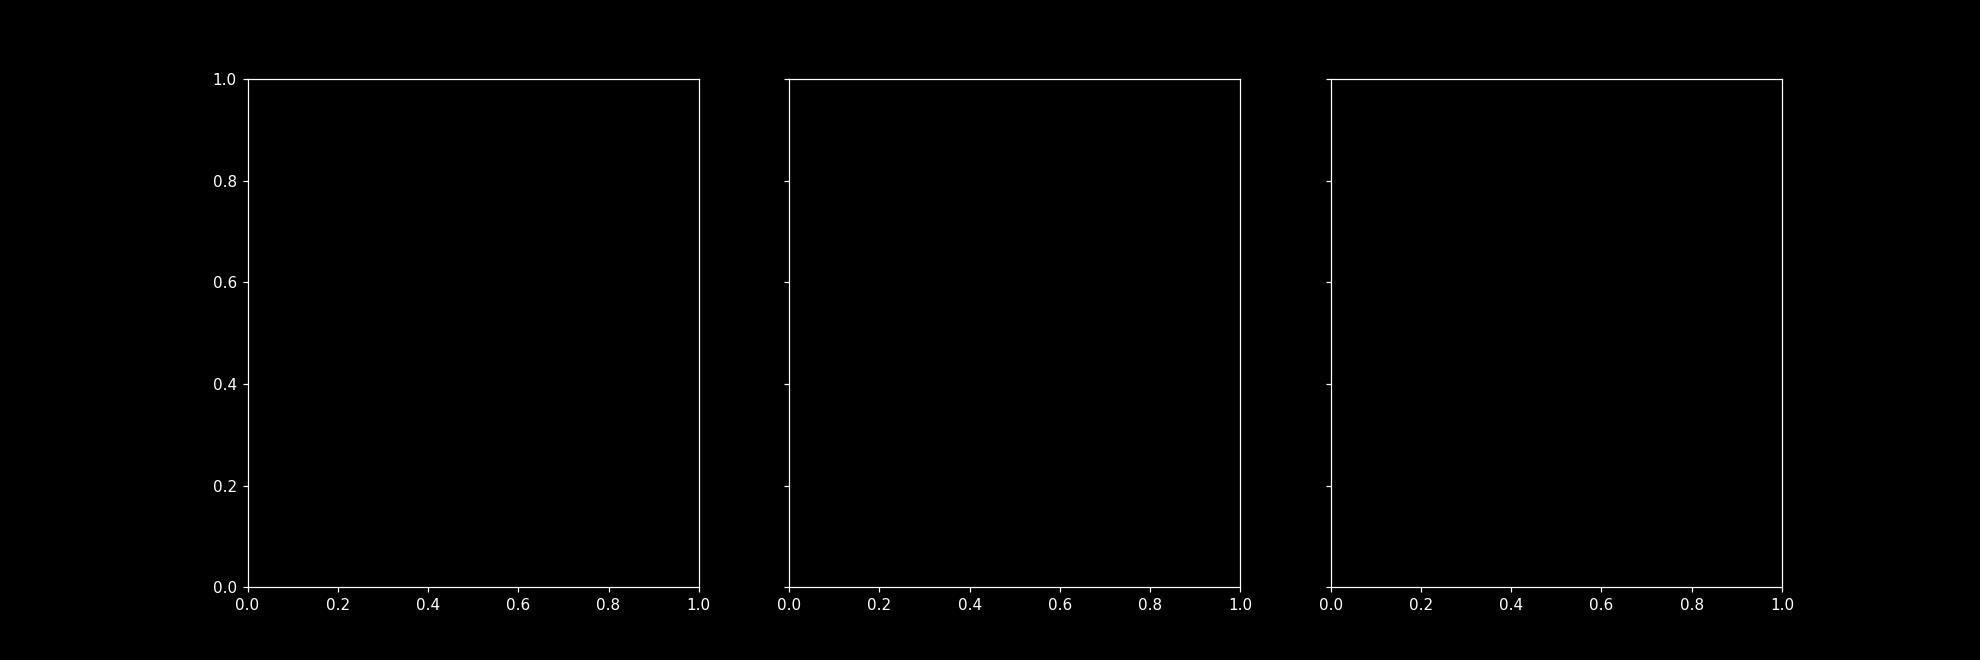

/tmp/ipykernel_261380/4234376958.py:479: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  filtered = filterPotential(torch.tensor(filtered).flatten(), torch.tensor(polySDF).flatten(), d0 = boundary).numpy().reshape(noise.shape)


ValueError: too many values to unpack (expected 12)

In [25]:


rows = 1
fig, axis = plt.subplots(rows, 3, figsize=(18,rows * 6), sharex = True, sharey = True, squeeze = False)
# fig, axis = plt.subplots(2, 3, figsize=(18,12), sharex = True, sharey = True, squeeze = False)
for i in range(rows):
    s = 32 / 2**i
    ptcls, vel, domainPtcls, domainGhostPtcls, domainSDF, domainSDFDer, centerPtcls, centerGhostPtcls, centerSDF, centerSDFDer, minDomain, minCenter = genParticles(nd = 8, nb = 32, border = border, n = n, res = res, octaves = octaves, lacunarity = lacunarity, persistance = persistance, seed = seed, boundary = boundaryWidth, dh = 1e-3)

    print('Number of fluid particles: ', ptcls.shape[0])
    print('Min/Max/Avg velocity: ', np.min(np.linalg.norm(vel, axis=1)), np.max(np.linalg.norm(vel, axis=1)), np.mean(np.linalg.norm(vel, axis=1)))
    print('Number of boundary particles (Domain): ', domainPtcls.shape[0])
    print('Number of boundary particles (Center): ', centerPtcls.shape[0])
    print('Number of particles: ', ptcls.shape[0] + domainPtcls.shape[0] + centerPtcls.shape[0])

    scatterPlot(ptcls[:,0], ptcls[:,1], vel[:,0], axis[i,0], fig, s = s)
    scatterPlot(ptcls[:,0], ptcls[:,1], vel[:,1], axis[i,1], fig, s = s)
    scatterPlot(ptcls[:,0], ptcls[:,1], np.linalg.norm(vel, axis=1), axis[i,2], fig, s = s)
    axis[i,0].scatter(np.hstack((domainPtcls[:,0], centerPtcls[:,0])), np.hstack((domainPtcls[:,1], centerPtcls[:,1])), c = 'white',s = s,alpha=0.5)
    axis[i,1].scatter(np.hstack((domainPtcls[:,0], centerPtcls[:,0])), np.hstack((domainPtcls[:,1], centerPtcls[:,1])), c = 'white',s = s,alpha=0.5)
    axis[i,2].scatter(np.hstack((domainPtcls[:,0], centerPtcls[:,0])), np.hstack((domainPtcls[:,1], centerPtcls[:,1])), c = 'white',s = s,alpha=0.5)

# scatterPlot(np.hstack((domainPtcls[:,0], centerPtcls[:,0])), np.hstack((domainPtcls[:,1], centerPtcls[:,1])), np.hstack((domainSDF, centerSDF)), axis[1,0], fig, s = s)
# scatterPlot(np.hstack((domainPtcls[:,0], centerPtcls[:,0])), np.hstack((domainPtcls[:,1], centerPtcls[:,1])), np.hstack((domainSDFDer[:,0], centerSDFDer[:,0])), axis[1,1], fig, s = s)
# scatterPlot(np.hstack((domainPtcls[:,0], centerPtcls[:,0])), np.hstack((domainPtcls[:,1], centerPtcls[:,1])), np.hstack((domainSDFDer[:,0], centerSDFDer[:,0])), axis[1,2], fig, s = s)
# axis[1,0].scatter(ptcls[:,0], ptcls[:,1], c ='white', s = s,alpha=0.5)
# axis[1,1].scatter(ptcls[:,0], ptcls[:,1], c ='white', s = s,alpha=0.5)
# axis[1,2].scatter(ptcls[:,0], ptcls[:,1], c ='white', s = s,alpha=0.5)

for axx in axis:
    for ax in axx:
        ax.axvline(minDomain, ls = '--')
        ax.axvline(-minDomain, ls = '--')
        ax.axhline(minDomain, ls = '--')
        ax.axhline(-minDomain, ls = '--')

fig.tight_layout()

In [44]:

def generateParticles(nd, nb, border = 3):
    if not isinstance(nd, np.ndarray):
        nd = np.array([nd,nd])
    if not isinstance(nb, np.ndarray):
        nb = np.array([nb,nb])
#     nd = 16
    nc = 2 * nd
#     nb = 32
    na = 2 * nb + nc
#     border = 3
    xi = np.arange(-border, na[0] + border, dtype = int) + border
    yi = np.arange(-border, na[1] + border, dtype = int) + border
    dx = 2 / (na[0] - 1) if na[0] > na[1] else 2 / (na[1] - 1)
    dy = dx
    px = xi * dx - 1 - border * dx
    
    
    py = yi * dy - 1 - border * dy
    # print(xi)
    # print(x)
    xx, yy = np.meshgrid(px,py)
    xxi, yyi = np.meshgrid(xi,yi)

    c = np.ones_like(xx)
#     print(xx.shape)

    c[xxi < border] = -1
    c[xxi >= na[0] + border] = -1
    c[yyi < border] = -1
    c[yyi >= na[1] + border] = -1
#     print(np.sum(c > 0) - 96**2)
    # print(96**2)

    maskA = xxi >= border + nb[0]
    maskB = yyi >= border + nb[1]
    maskAB = np.logical_and(maskA, maskB)

    maskC = xxi < border + nb[0] + nc[0]
    maskD = yyi < border + nb[1] + nc[1]
    maskCD = np.logical_and(maskC, maskD)

    mask = np.logical_and(maskAB, maskCD)
#     print(np.sum(mask))
    c[mask] = -1

    maskA = xxi >= 2 * border + nb[0]
    maskB = yyi >= 2 * border + nb[1]
    maskAB = np.logical_and(maskA, maskB)

    maskC = xxi < border + nb[0] + nc[0] - border
    maskD = yyi < border + nb[1] + nc[1] - border
    maskCD = np.logical_and(maskC, maskD)

    mask = np.logical_and(maskAB, maskCD)
#     print(np.sum(mask))
    c[mask] = 0.25
    # c[:,:] = -0.5


    minDomain = -1 - dx / 2
    minCenter = - nd * dx# - dx / 2
#     print(dx)
#     print(-nd * dx)
#     print(minCenter)


#     fig, axis = plt.subplots(1, 1, figsize=(6,6), sharex = False, sharey = False, squeeze = False)

    ptcls = np.vstack((xx[c > 0.5], yy[c>0.5])).transpose()
    bdyPtcls = np.vstack((xx[c < -0.5], yy[c <-0.5])).transpose()
    
    center = (np.max(bdyPtcls,axis=0) + np.min(bdyPtcls,axis=0))/2
#     print(center)
    ptcls = ptcls - center
    bdyPtcls = bdyPtcls - center
    
    return ptcls, bdyPtcls, minDomain, minCenter

<IPython.core.display.Javascript object>


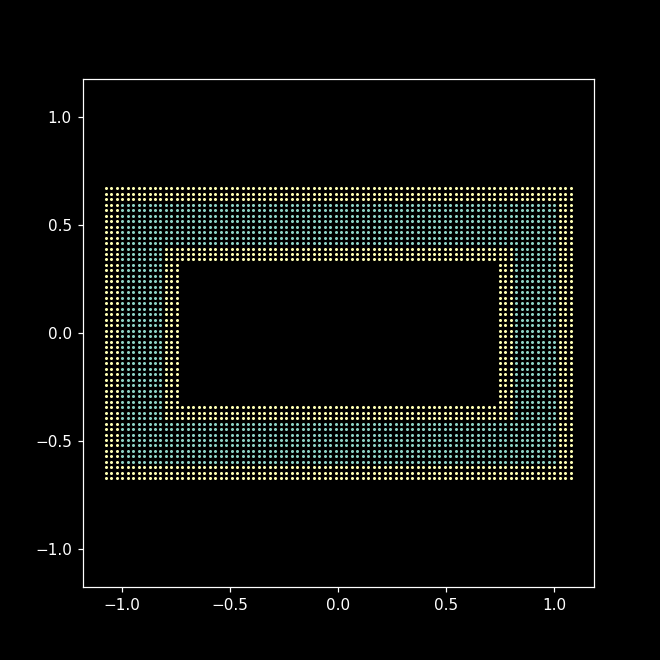

(-1.1835443037974682,
 1.1835443037974682,
 -0.7379746835443038,
 0.7379746835443038)

In [46]:
fluid, bdy, minDomain, minCenter = generateParticles(np.array([32,16]),8)

fig, axis = plt.subplots(1, 1, figsize=(6,6), sharex = True, sharey = True, squeeze = False)

axis[0,0].scatter(fluid[:,0], fluid[:,1],s = 1)
axis[0,0].scatter(bdy[:,0], bdy[:,1],s = 1)

axis[0,0].axis('equal')